In [97]:
import torch
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms

import matplotlib.pyplot as plt

import librosa
import numpy as np

from pathlib import Path

%cd ../io
from load import readAudio, readAnnotations, compute_log_filterbank, compute_log_filter_spectrogram
%cd ..
from preprocess import invert_mel_spectrogram, invert_log_filter_spectrogram
%cd notebooks

import IPython

/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/io
/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis
/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/notebooks


/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Display some example spectrograms

In [98]:
path = Path("../data/SADTP/Red Swan/mix.wav")

waveform, sr = torchaudio.load(path)
waveform = waveform.mean(dim=0)[sr*215:sr*220]

spectrogram = torchaudio.transforms.Spectrogram(n_fft=512, win_length=512, hop_length=sr // 100, power=1)(waveform)
log_spectrogram = torch.log10(spectrogram + 1)

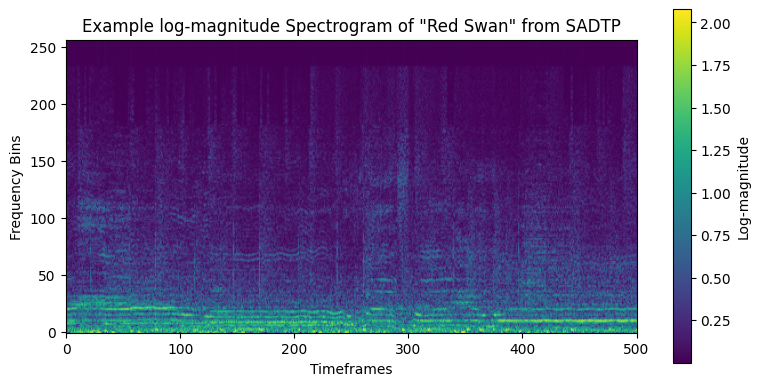

In [100]:
fig, ax = plt.subplots(figsize=(8, 4))
image = ax.imshow(log_spectrogram)
plt.colorbar(image, label="Log-magnitude")
ax.invert_yaxis()

plt.title('Example log-magnitude Spectrogram of "Red Swan" from SADTP')
ax.set_ylabel("Frequency Bins")
ax.set_xlabel("Timeframes")

fig.tight_layout()
plt.savefig("../thesis/figures/logspectrogram.png", bbox_inches='tight')
plt.show()

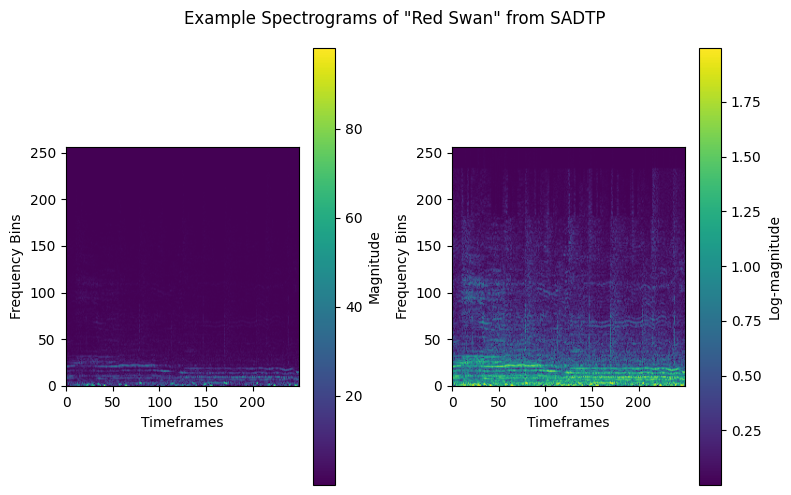

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
left, right = axes[0].imshow(spectrogram[:, :250]), axes[1].imshow(log_spectrogram[:, :250])
plt.colorbar(left, label="Magnitude")
plt.colorbar(right, label="Log-magnitude")
axes[0].invert_yaxis()
axes[1].invert_yaxis()

axes[0].set_ylabel("Frequency Bins")
axes[0].set_xlabel("Timeframes")
axes[1].set_ylabel("Frequency Bins")
axes[1].set_xlabel("Timeframes")

plt.suptitle('Example Spectrograms of "Red Swan" from SADTP')
fig.tight_layout()
plt.savefig("../thesis/figures/spectrogramlogspectrogram.png", bbox_inches='tight')
plt.show()